Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/ResNet.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FResNet.ipynb&branch=main" target="_blank">Rosenblatt</a>

ResNet pour la classification
=============================

Dans ce notebook on cherche à implémente un réseau ResNet pour la classification et on va chercher à montrer l'importance des connections résiduelles pour l'entraînement.

On reprend le modèle déjà vu pour le notebook sur le Transfer Learning.

In [8]:
%matplotlib inline

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion();   # interactive mode

Chargement des données
----------------------

In [10]:
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}


data_dir = 'STL10'

train_dataset = torchvision.datasets.STL10(root=data_dir, split="train",
                                                  transform=data_transforms["train"],
                                                  download=True)
val_dataset = torchvision.datasets.STL10(root=data_dir, split="test", folds=0,
                                                  transform=data_transforms["val"],
                                                  download=True)
test_dataset = torchvision.datasets.STL10(root=data_dir, split="test", folds=1,
                                                  transform=data_transforms["val"],
                                                  download=True)

image_datasets = {"train": train_dataset, "val": val_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val data:


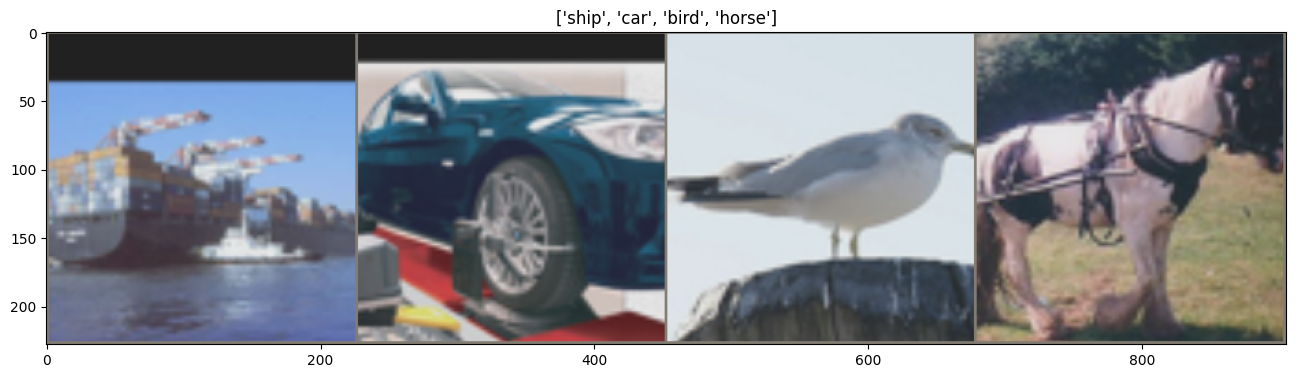

train data:


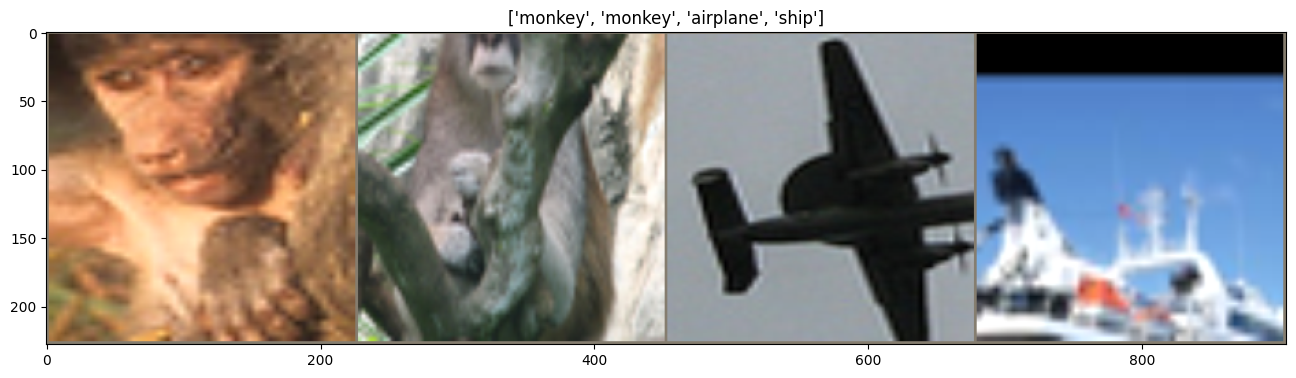

In [11]:
def imshow(inp, title=None, rescale=True):
    """Imshow for Tensor."""
    if len(inp.shape)==2:
      inp = np.tile(inp[None,:,:],(3,1,1))
    if rescale:
      inp = (inp - np.mean(inp)) / (4*np.std(inp)) + .5
    inp = inp.transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Display a row of teest data and a row of train data
for data_type in 'val', 'train':
  inputs, classes = next(iter(dataloaders[data_type]))
  inputs = torchvision.utils.make_grid(inputs)
  inputs = inputs.numpy() * np.array(normalize_std)[:,None,None] + np.array(normalize_mean)[:,None,None]
  print(data_type,'data:')
  plt.figure(figsize=(16,8))
  imshow(inputs, title=[class_names[x] for x in classes])
  plt.show()

Entraînement du réseau
----------------------

On écrit une fonction classique pour l'entraînement:

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Définition du réseau ResNet
---------------------------

Le code suivant est une copie simplifiée du code source de PyTorch pour la définition de ResNet.

In [13]:
from functools import partial

import torch
import torch.nn as nn
from torch import Tensor

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, 
                 dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, 
                 dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, 
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor):
        return self._forward_impl(x)


def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def resnet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def resnet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

Entraînement
------------

On adapte le modèle pour la classification en 10 classes et on entraîne.

In [49]:
model_ft = resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2168 Acc: 0.1882
val Loss: 2.0257 Acc: 0.2854

Epoch 1/19
----------
train Loss: 2.0037 Acc: 0.2616
val Loss: 1.6931 Acc: 0.3663

Epoch 2/19
----------
train Loss: 1.9131 Acc: 0.2904
val Loss: 1.7464 Acc: 0.3330

Epoch 3/19
----------
train Loss: 1.8556 Acc: 0.3164
val Loss: 1.5603 Acc: 0.4085

Epoch 4/19
----------
train Loss: 1.7747 Acc: 0.3502
val Loss: 1.4461 Acc: 0.4645

Epoch 5/19
----------
train Loss: 1.7206 Acc: 0.3684
val Loss: 1.5303 Acc: 0.4305

Epoch 6/19
----------
train Loss: 1.6774 Acc: 0.3910
val Loss: 1.4227 Acc: 0.4841

Epoch 7/19
----------
train Loss: 1.4895 Acc: 0.4554
val Loss: 1.2572 Acc: 0.5416

Epoch 8/19
----------
train Loss: 1.4590 Acc: 0.4608
val Loss: 1.2896 Acc: 0.5375

Epoch 9/19
----------
train Loss: 1.4169 Acc: 0.4786
val Loss: 1.3256 Acc: 0.5371

Epoch 10/19
----------
train Loss: 1.4172 Acc: 0.4810
val Loss: 1.2982 Acc: 0.5396

Epoch 11/19
----------
train Loss: 1.3924 Acc: 0.4904
val Loss: 1.2172 Acc: 0.5593

Ep

Visualisation des résultats
---------------------------

In [17]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(16,8))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//4, 4, images_so_far)
                plt.axis('off')
                plt.title('predicted: {}'.format(class_names[preds[j]]))

                inp = inputs.cpu().data[j].numpy() * np.array(normalize_std)[:,None,None] + np.array(normalize_mean)[:,None,None]
                imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    plt.show()

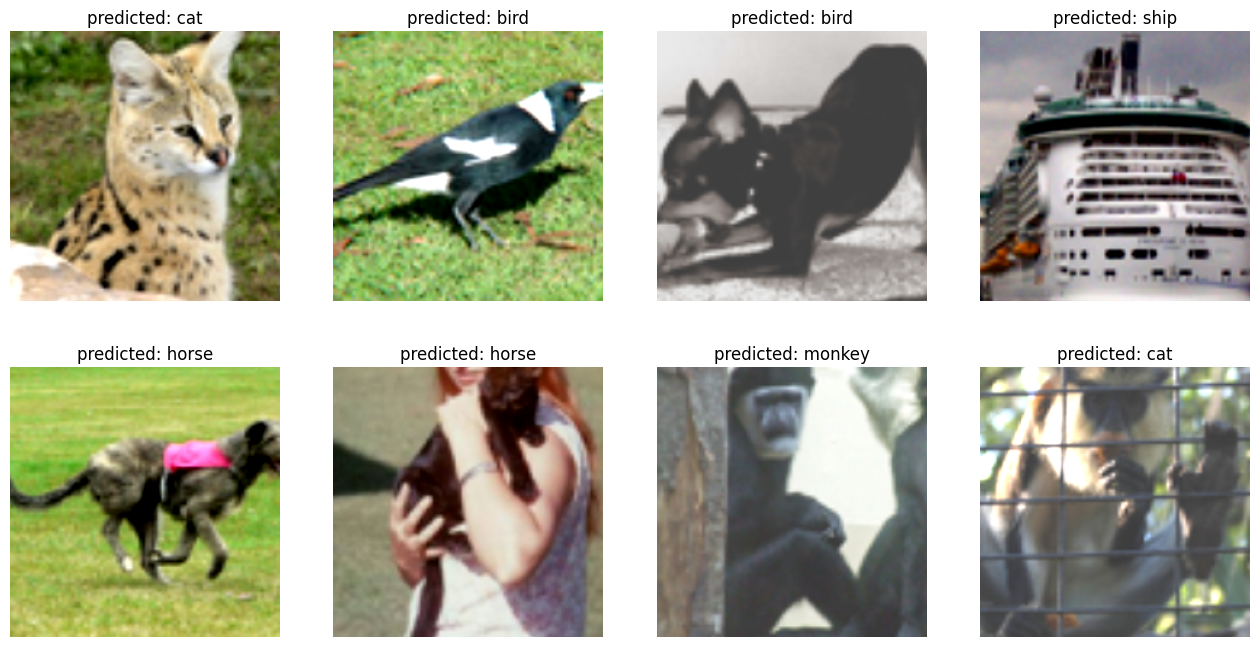

In [50]:
visualize_model(model_ft)

Suppression des connections résiduelles
---------------------------------------

On récrit certaines parties du code ResNet pour supprimer les connections résiduelles

In [15]:
class BasicBlock_plain(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, 
                 dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.relu(out)

        return out

class Bottleneck_plain(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, 
                 dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.relu(out)

        return out

def resnet18_plain():
    return ResNet(BasicBlock_plain, [2, 2, 2, 2])

def resnet34_plain():
    return ResNet(BasicBlock_plain, [3, 4, 6, 3])

def resnet50_plain():
    return ResNet(Bottleneck_plain, [3, 4, 6, 3])

def resnet101_plain():
    return ResNet(Bottleneck_plain, [3, 4, 23, 3])

def resnet152_plain():
    return ResNet(Bottleneck_plain, [3, 8, 36, 3])

Test d'entraînement sans connections résiduelles
------------------------------------------------

In [16]:
model_ft = resnet18_plain()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

visualize_model(model_ft)

Epoch 0/19
----------
train Loss: 2.1313 Acc: 0.1764
val Loss: 1.8425 Acc: 0.2810

Epoch 1/19
----------
train Loss: 2.0091 Acc: 0.2284
val Loss: 1.6558 Acc: 0.3266

Epoch 2/19
----------
train Loss: 1.9300 Acc: 0.2692
val Loss: 1.6091 Acc: 0.3842

Epoch 3/19
----------
train Loss: 1.8993 Acc: 0.2904
val Loss: 1.6760 Acc: 0.3814

Epoch 4/19
----------
train Loss: 1.8539 Acc: 0.3028
val Loss: 1.6793 Acc: 0.3670

Epoch 5/19
----------
train Loss: 1.8015 Acc: 0.3424
val Loss: 1.5292 Acc: 0.4600

Epoch 6/19
----------
train Loss: 1.7559 Acc: 0.3538
val Loss: 1.4107 Acc: 0.4769

Epoch 7/19
----------
train Loss: 1.6345 Acc: 0.4074
val Loss: 1.3780 Acc: 0.5085

Epoch 8/19
----------
train Loss: 1.5660 Acc: 0.4314
val Loss: 1.3056 Acc: 0.5389

Epoch 9/19
----------
train Loss: 1.5516 Acc: 0.4354
val Loss: 1.3350 Acc: 0.5330

Epoch 10/19
----------
train Loss: 1.5560 Acc: 0.4418
val Loss: 1.3577 Acc: 0.5328

Epoch 11/19
----------
train Loss: 1.5339 Acc: 0.4596
val Loss: 1.3076 Acc: 0.5438

Ep

NameError: name 'visualize_model' is not defined

Entraînement avec et sans connections résiduelles pour le réseau ResNet50
-------------------------------------------------------------------------

Epoch 0/19
----------
train Loss: 2.7129 Acc: 0.1668
val Loss: 7.3194 Acc: 0.2284

Epoch 1/19
----------
train Loss: 2.1959 Acc: 0.2150
val Loss: 6.2265 Acc: 0.2205

Epoch 2/19
----------
train Loss: 2.0788 Acc: 0.2176
val Loss: 3.3742 Acc: 0.2642

Epoch 3/19
----------
train Loss: 2.0057 Acc: 0.2436
val Loss: 3.5230 Acc: 0.2782

Epoch 4/19
----------
train Loss: 1.9618 Acc: 0.2514
val Loss: 3.5247 Acc: 0.3046

Epoch 5/19
----------
train Loss: 1.9196 Acc: 0.2826
val Loss: 7.2090 Acc: 0.3061

Epoch 6/19
----------
train Loss: 1.9029 Acc: 0.2760
val Loss: 3.1732 Acc: 0.3237

Epoch 7/19
----------
train Loss: 1.7927 Acc: 0.3134
val Loss: 3.0432 Acc: 0.3631

Epoch 8/19
----------
train Loss: 1.7765 Acc: 0.3364
val Loss: 2.0926 Acc: 0.3831

Epoch 9/19
----------
train Loss: 1.7658 Acc: 0.3284
val Loss: 2.4525 Acc: 0.3788

Epoch 10/19
----------
train Loss: 1.7432 Acc: 0.3308
val Loss: 2.4284 Acc: 0.3847

Epoch 11/19
----------
train Loss: 1.7147 Acc: 0.3508
val Loss: 1.9656 Acc: 0.3852

Ep

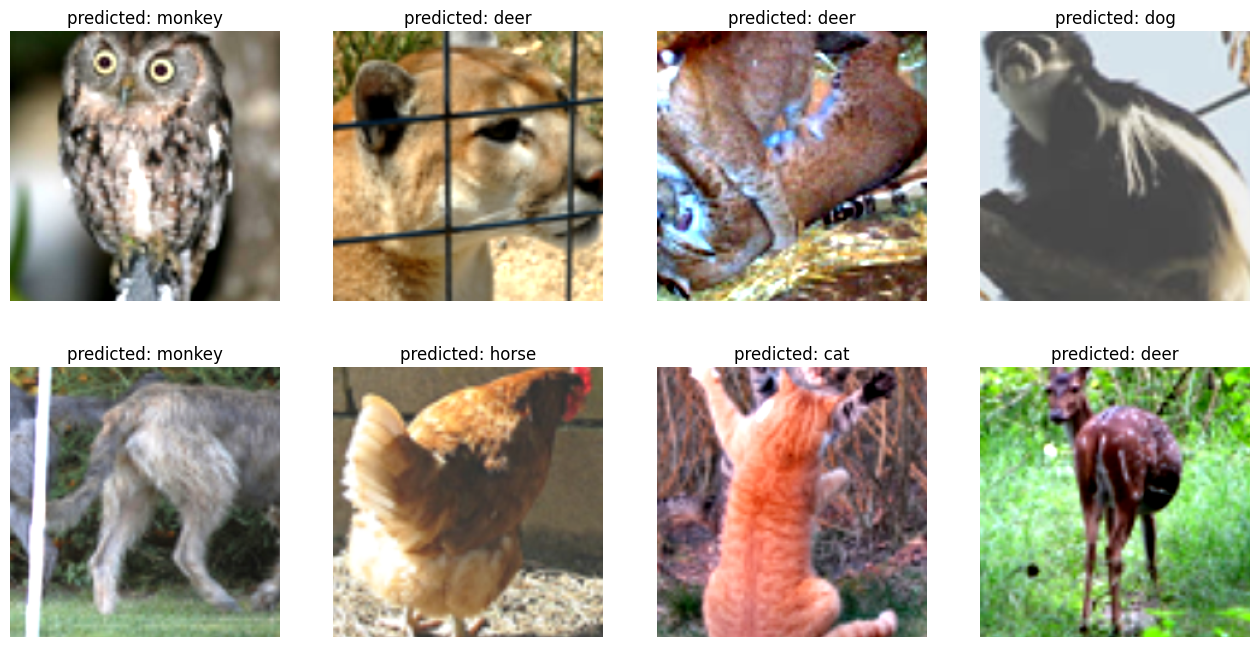

In [19]:
model_ft = resnet50()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

visualize_model(model_ft)

In [ ]:
model_ft = resnet50_plain()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

visualize_model(model_ft)

Epoch 0/19
----------
train Loss: 2.3945 Acc: 0.1250
val Loss: 2.6456 Acc: 0.1621

Epoch 1/19
----------
